In [5]:
import os
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import torchvision.utils as vutils
from PIL import Image

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'C:/Users/merye/Desktop/IP102_Wheat_Cereal_Pests'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print(f"Dataset loaded with {len(class_names)} classes")
print(f"Training set: {dataset_sizes['train']} images")
print(f"Validation set: {dataset_sizes['val']} images")

Dataset loaded with 18 classes
Training set: 4486 images
Validation set: 746 images


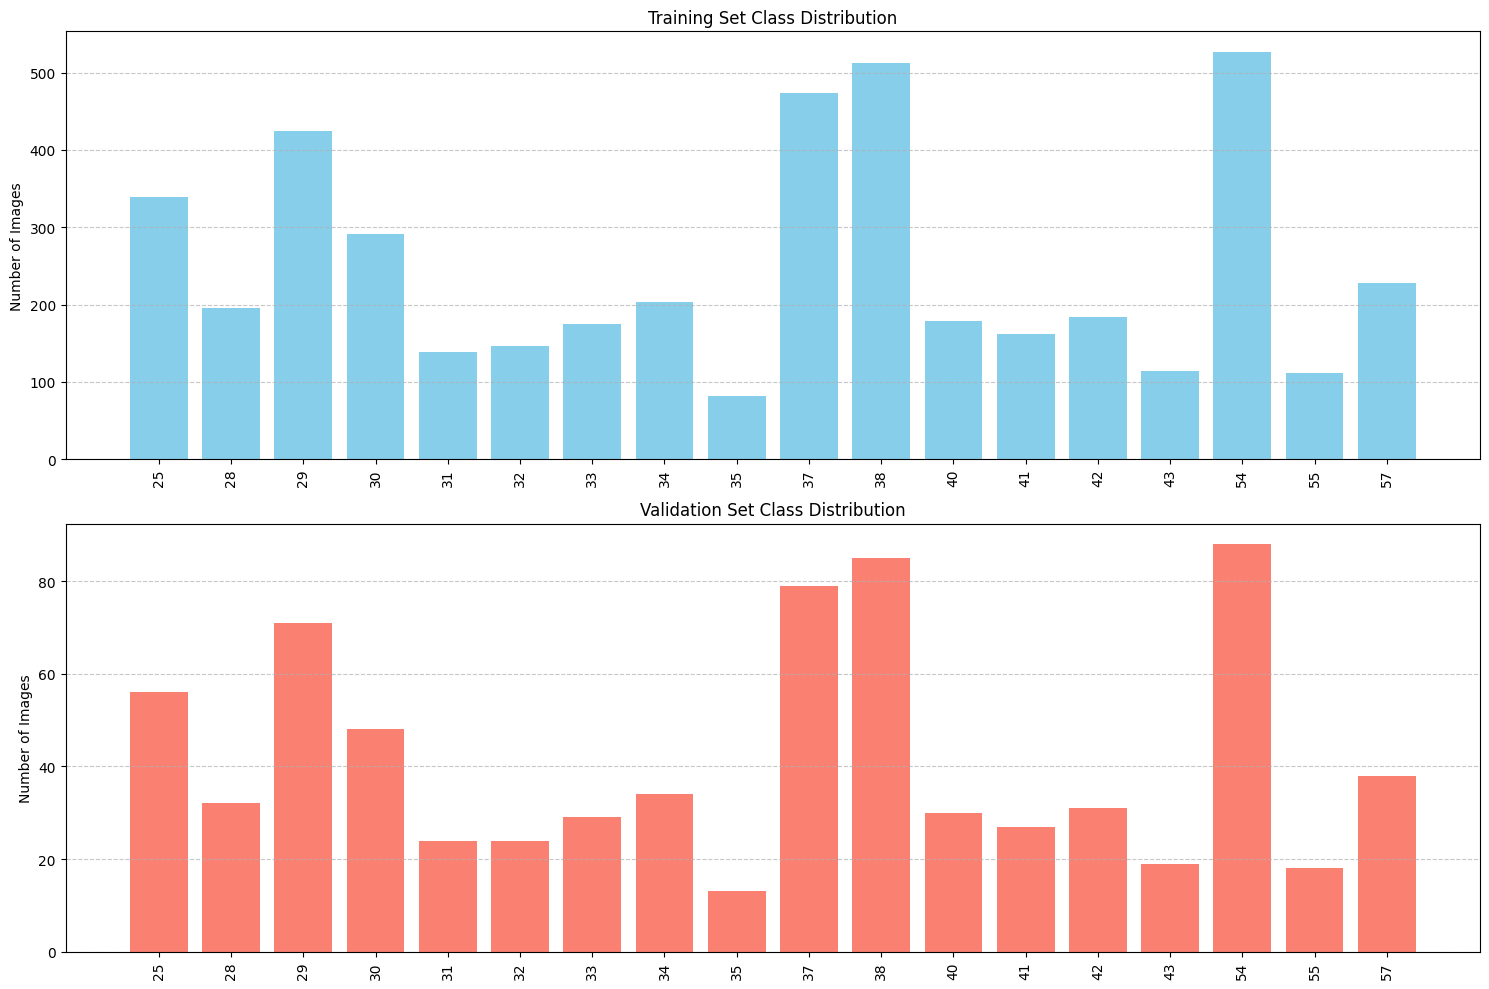


Class Distribution Statistics:
----------------------------------------
Number of classes: 18
Most common class in training set: ('54', 527)
Least common class in training set: ('35', 82)
Class imbalance ratio (max/min): 6.43


In [7]:
plt.figure(figsize=(15, 10))

train_targets = [image_datasets['train'].targets[i] for i in range(len(image_datasets['train']))]
train_class_counts = Counter(train_targets)
sorted_train_counts = {class_names[k]: train_class_counts[k] for k in sorted(train_class_counts.keys())}

plt.subplot(2, 1, 1)
plt.bar(sorted_train_counts.keys(), sorted_train_counts.values(), color='skyblue')
plt.title('Training Set Class Distribution')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

val_targets = [image_datasets['val'].targets[i] for i in range(len(image_datasets['val']))]
val_class_counts = Counter(val_targets)
sorted_val_counts = {class_names[k]: val_class_counts[k] for k in sorted(val_class_counts.keys())}

plt.subplot(2, 1, 2)
plt.bar(sorted_val_counts.keys(), sorted_val_counts.values(), color='salmon')
plt.title('Validation Set Class Distribution')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# 2. Print statistics about the dataset
print("\nClass Distribution Statistics:")
print("-" * 40)
print(f"Number of classes: {num_classes}")
print(f"Most common class in training set: {max(sorted_train_counts.items(), key=lambda x: x[1])}")
print(f"Least common class in training set: {min(sorted_train_counts.items(), key=lambda x: x[1])}")

max_count = max(sorted_train_counts.values())
min_count = min(sorted_train_counts.values())
imbalance_ratio = max_count / min_count
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

In [8]:
def create_teacher_model():
    model = models.vit_b_16(weights='IMAGENET1K_V1')
    model.heads = nn.Sequential(
        nn.Linear(model.hidden_dim, 512),
        nn.LayerNorm(512),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

def create_resnet_student():
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.6),
        nn.Linear(num_ftrs, num_classes)
    )
    return model.to(device)

def create_efficientnet_student():
    model = models.efficientnet_b2(weights="DEFAULT")
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.6),
        nn.Linear(num_ftrs, num_classes)
    )
    return model.to(device)

In [10]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=2.0):
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, student_outputs, teacher_outputs, targets):
        # Hard loss: cross-entropy with true labels
        hard_loss = self.ce_loss(student_outputs, targets)
        
        # Soft loss: KL divergence between softened distributions
        soft_student = F.log_softmax(student_outputs / self.temperature, dim=1)
        soft_teacher = F.softmax(teacher_outputs / self.temperature, dim=1)
        soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (self.temperature ** 2)
        
        # Combined loss
        return hard_loss * (1 - self.alpha) + soft_loss * self.alpha

In [11]:
def load_model(model_creator, model_path, model_name="Model"):
    """Load a model from a saved .pth file."""
    model = model_creator()
    
    try:
        checkpoint = torch.load(model_path, map_location=device)
        
        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
            
        print(f"{model_name} loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading {model_name} from {model_path}: {e}")
        return None

Loading models...
Teacher (ViT) loaded successfully from vit_insect_classifier.pth
ResNet50 loaded successfully from resnet50_finetuned.pth
EfficientNetB2 loaded successfully from efficientnet_b2_finetuned.pth

----- Initial Model Evaluation -----
Evaluating Teacher (ViT):


Evaluating Teacher_ViT_Initial: 100%|██████████████████████████████████████████████████| 24/24 [00:15<00:00,  1.51it/s]


Teacher_ViT_Initial Accuracy: 82.04%

Classification Report for Teacher_ViT_Initial:
              precision    recall  f1-score   support

          25       0.86      0.98      0.92        56
          28       0.50      0.44      0.47        32
          29       0.76      0.76      0.76        71
          30       0.96      0.96      0.96        48
          31       0.71      0.62      0.67        24
          32       0.67      0.67      0.67        24
          33       0.79      0.66      0.72        29
          34       0.89      0.91      0.90        34
          35       0.73      0.62      0.67        13
          37       0.91      0.92      0.92        79
          38       0.87      0.88      0.88        85
          40       0.78      0.83      0.81        30
          41       0.96      0.85      0.90        27
          42       0.94      0.97      0.95        31
          43       0.82      0.74      0.78        19
          54       0.74      0.84      0.79       

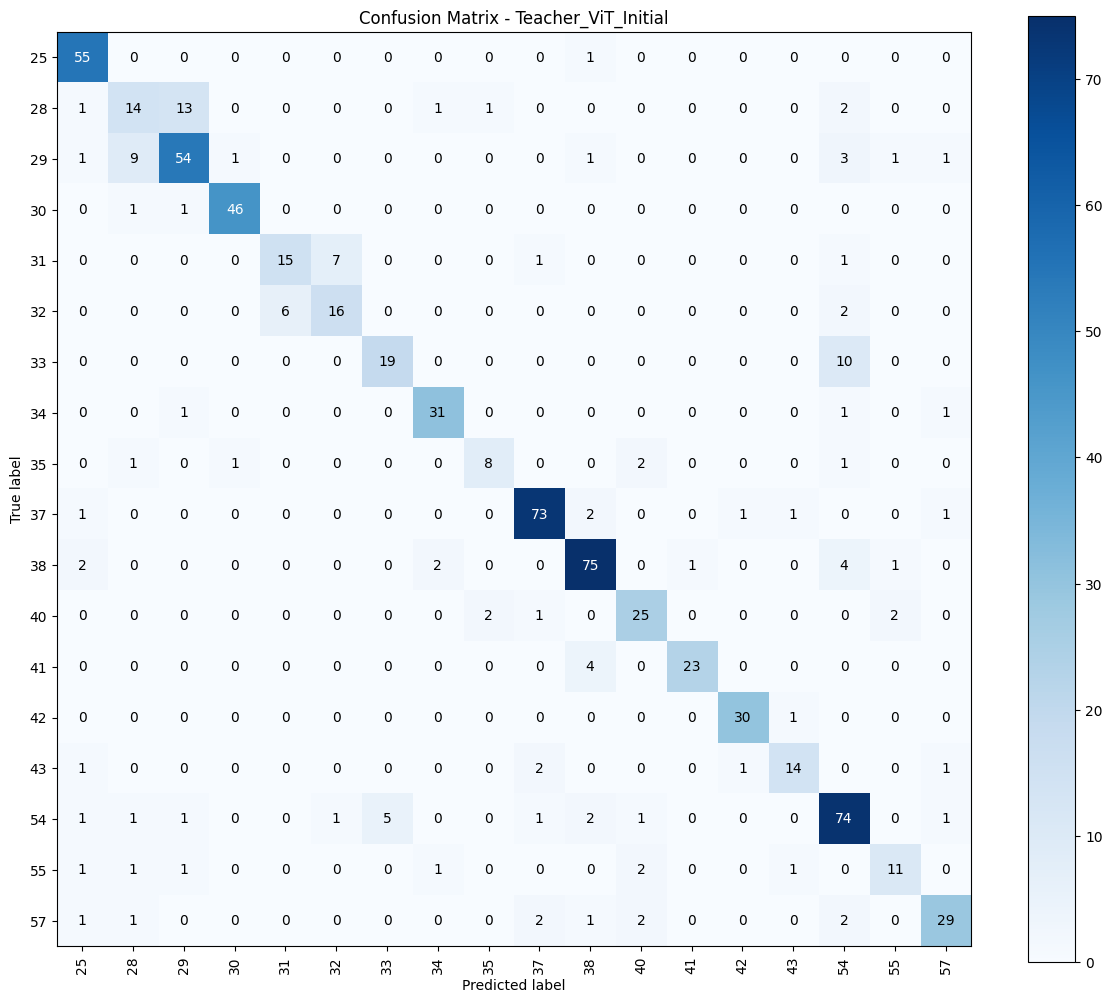


Evaluating ResNet50 Student (Before Distillation):


Evaluating ResNet50_Initial: 100%|█████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.43it/s]


ResNet50_Initial Accuracy: 82.04%

Classification Report for ResNet50_Initial:
              precision    recall  f1-score   support

          25       0.90      0.95      0.92        56
          28       0.52      0.47      0.49        32
          29       0.76      0.76      0.76        71
          30       0.94      0.94      0.94        48
          31       0.70      0.58      0.64        24
          32       0.62      0.67      0.64        24
          33       0.84      0.55      0.67        29
          34       0.91      0.91      0.91        34
          35       0.62      0.62      0.62        13
          37       0.87      0.97      0.92        79
          38       0.93      0.88      0.90        85
          40       0.83      0.83      0.83        30
          41       0.93      0.93      0.93        27
          42       1.00      0.94      0.97        31
          43       0.92      0.63      0.75        19
          54       0.74      0.84      0.79        88
  

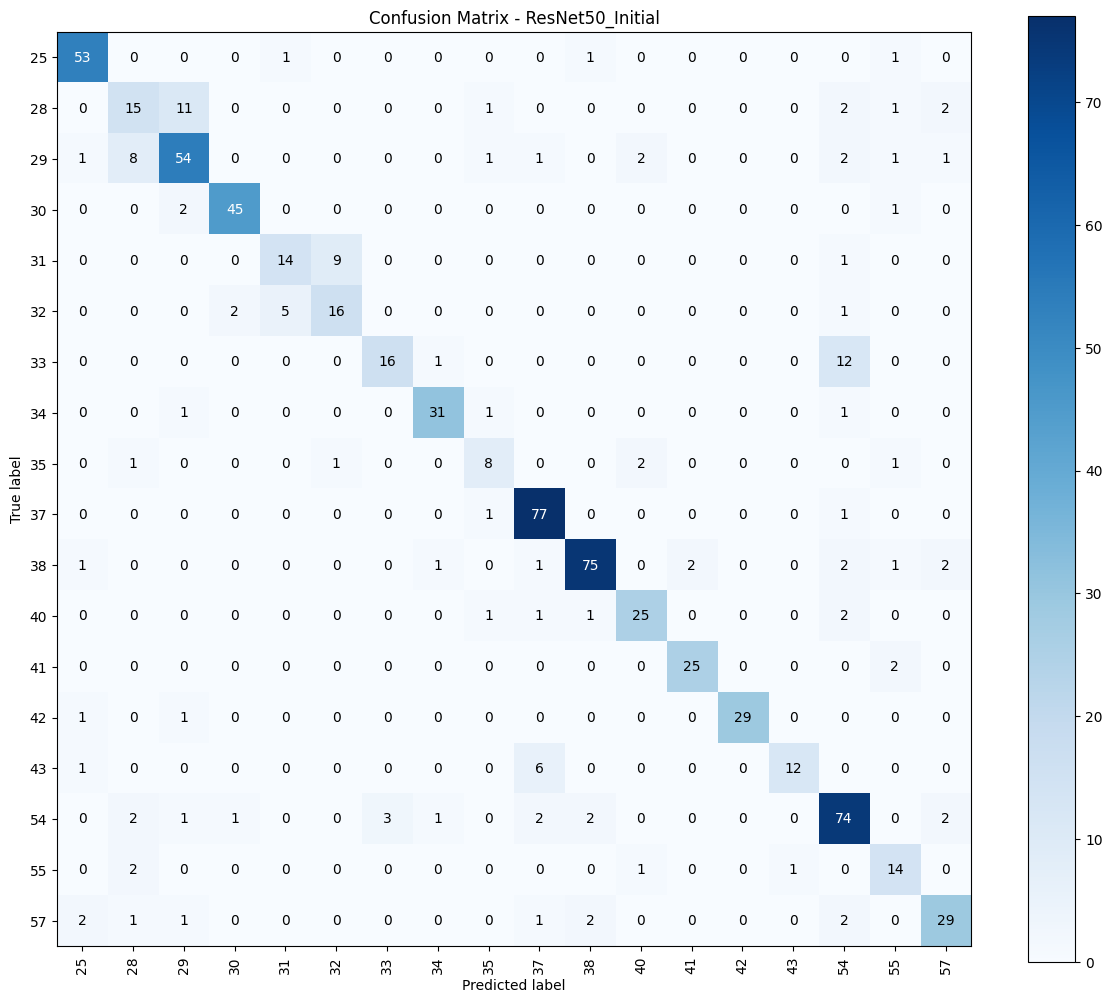


Evaluating EfficientNetB2 Student (Before Distillation):


Evaluating EfficientNetB2_Initial: 100%|███████████████████████████████████████████████| 24/24 [00:09<00:00,  2.66it/s]


EfficientNetB2_Initial Accuracy: 82.98%

Classification Report for EfficientNetB2_Initial:
              precision    recall  f1-score   support

          25       0.96      0.93      0.95        56
          28       0.49      0.53      0.51        32
          29       0.74      0.75      0.74        71
          30       0.96      0.96      0.96        48
          31       0.71      0.62      0.67        24
          32       0.72      0.75      0.73        24
          33       0.73      0.83      0.77        29
          34       0.94      0.88      0.91        34
          35       0.80      0.62      0.70        13
          37       0.91      0.97      0.94        79
          38       0.89      0.94      0.91        85
          40       0.78      0.70      0.74        30
          41       1.00      0.81      0.90        27
          42       0.94      1.00      0.97        31
          43       0.94      0.79      0.86        19
          54       0.77      0.83      0.80 

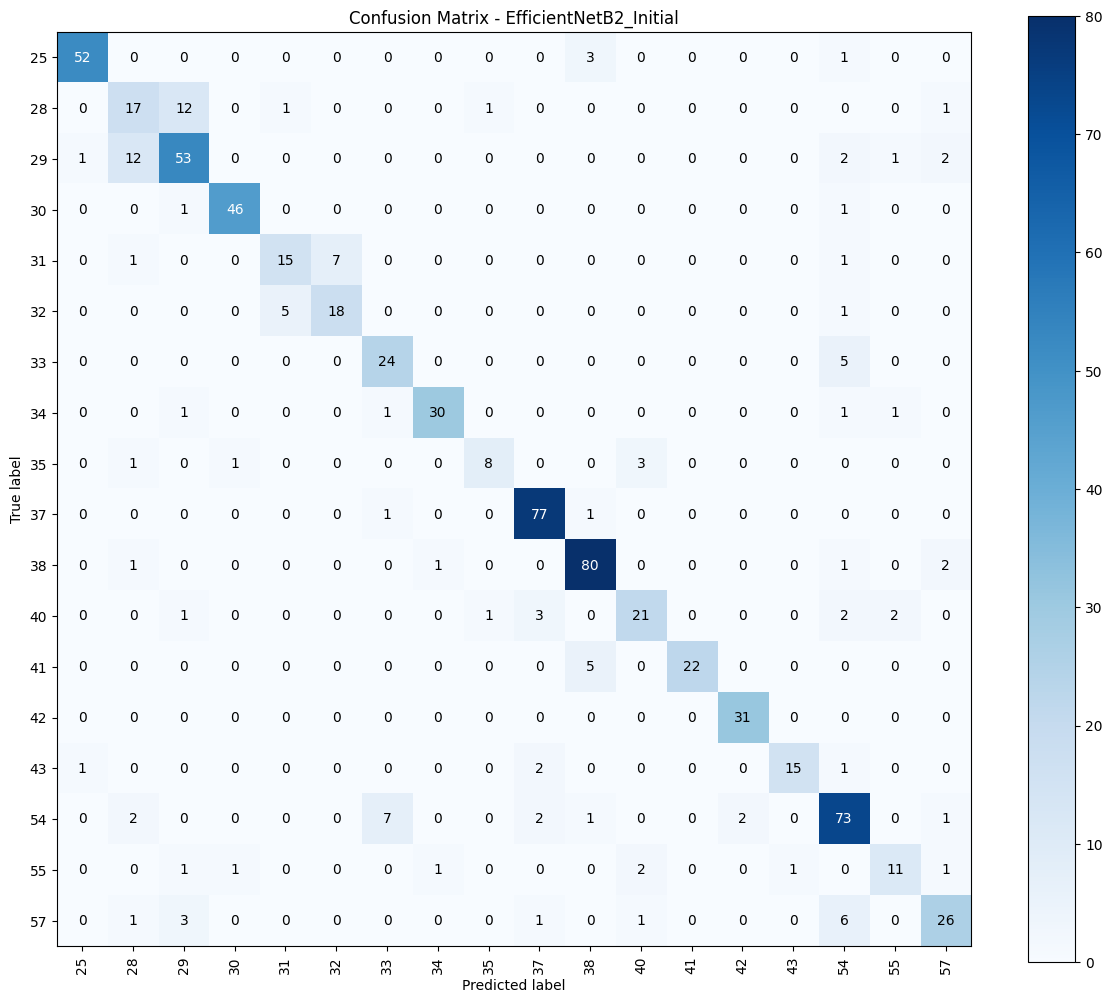


----- Starting Knowledge Distillation -----

----- Distilling to ResNet50 -----
Epoch 1/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████| 141/141 [01:55<00:00,  1.22it/s]


train Loss: 1.6751 Acc: 0.7274


val: 100%|█████████████████████████████████████████████████████████████████████████████| 24/24 [00:27<00:00,  1.13s/it]


val Loss: 0.8430 Acc: 0.7681
Saved improved model to resnet50_distilled.pth

Epoch 2/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████| 141/141 [01:42<00:00,  1.38it/s]


train Loss: 1.5174 Acc: 0.7448


val: 100%|█████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  2.00it/s]


val Loss: 0.7700 Acc: 0.7748
Saved improved model to resnet50_distilled.pth

Epoch 3/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.79it/s]


train Loss: 1.3161 Acc: 0.7831


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


val Loss: 0.7923 Acc: 0.7681

Epoch 4/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.81it/s]


train Loss: 1.2036 Acc: 0.7914


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.96it/s]


val Loss: 0.7640 Acc: 0.7855
Saved improved model to resnet50_distilled.pth

Epoch 5/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.79it/s]


train Loss: 1.0654 Acc: 0.8121


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


val Loss: 0.7644 Acc: 0.7828

Epoch 6/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.9176 Acc: 0.8422


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.00it/s]


val Loss: 0.6698 Acc: 0.8110
Saved improved model to resnet50_distilled.pth

Epoch 7/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.8595 Acc: 0.8533


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.02it/s]


val Loss: 0.6215 Acc: 0.8123
Saved improved model to resnet50_distilled.pth

Epoch 8/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.7825 Acc: 0.8700


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.96it/s]


val Loss: 0.6433 Acc: 0.8177
Saved improved model to resnet50_distilled.pth

Epoch 9/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.79it/s]


train Loss: 0.7318 Acc: 0.8810


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.97it/s]


val Loss: 0.6304 Acc: 0.8204
Saved improved model to resnet50_distilled.pth

Epoch 10/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.7133 Acc: 0.8767


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


val Loss: 0.6129 Acc: 0.8271
Saved improved model to resnet50_distilled.pth

Epoch 11/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.79it/s]


train Loss: 0.7039 Acc: 0.8870


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.94it/s]


val Loss: 0.6320 Acc: 0.8231

Epoch 12/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.79it/s]


train Loss: 0.7251 Acc: 0.8836


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.95it/s]


val Loss: 0.6264 Acc: 0.8338
Saved improved model to resnet50_distilled.pth

Epoch 13/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.7211 Acc: 0.8823


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.94it/s]


val Loss: 0.6348 Acc: 0.8204

Epoch 14/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.7261 Acc: 0.8718


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.98it/s]


val Loss: 0.6444 Acc: 0.8110

Epoch 15/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.7150 Acc: 0.8852


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.00it/s]


val Loss: 0.6440 Acc: 0.8231

Epoch 16/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.80it/s]


train Loss: 0.7909 Acc: 0.8651


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.98it/s]


val Loss: 0.6695 Acc: 0.8016

Epoch 17/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:18<00:00,  1.79it/s]


train Loss: 0.8269 Acc: 0.8609


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.00it/s]


val Loss: 0.6996 Acc: 0.8003
Early stopping triggered after 17 epochs! Best model restored.


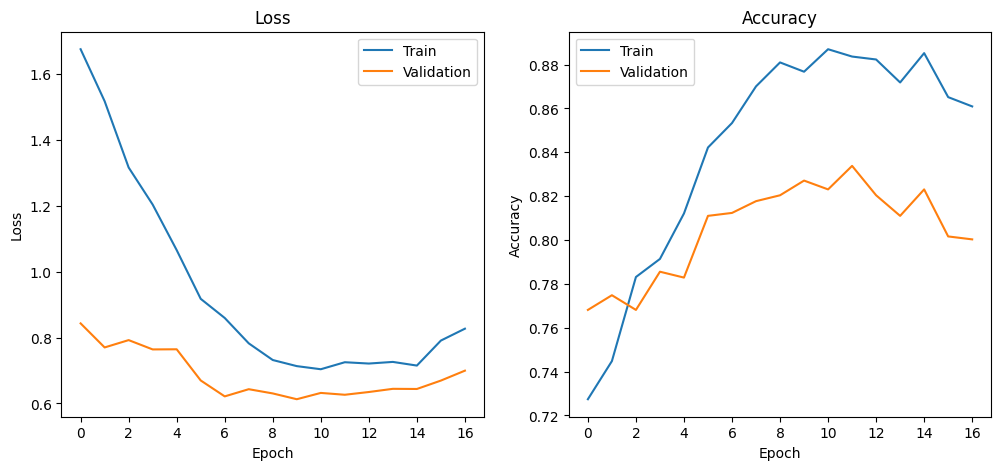


----- Distilling to EfficientNetB2 -----
Epoch 1/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:13<00:00,  1.91it/s]


train Loss: 1.1867 Acc: 0.8529


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.03it/s]


val Loss: 0.6182 Acc: 0.8271
Saved improved model to efficientnet_b2_distilled.pth

Epoch 2/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:13<00:00,  1.91it/s]


train Loss: 0.9820 Acc: 0.8466


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.05it/s]


val Loss: 0.6346 Acc: 0.8123

Epoch 3/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:14<00:00,  1.90it/s]


train Loss: 0.9040 Acc: 0.8678


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.11it/s]


val Loss: 0.6306 Acc: 0.8217

Epoch 4/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:14<00:00,  1.91it/s]


train Loss: 0.8756 Acc: 0.8647


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.10it/s]


val Loss: 0.6428 Acc: 0.8150

Epoch 5/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:14<00:00,  1.89it/s]


train Loss: 0.8542 Acc: 0.8651


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.11it/s]


val Loss: 0.6428 Acc: 0.8164

Epoch 6/30
--------------------------------------------------


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [01:14<00:00,  1.90it/s]


train Loss: 0.8191 Acc: 0.8707


val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.10it/s]


val Loss: 0.6326 Acc: 0.8137
Early stopping triggered after 6 epochs! Best model restored.


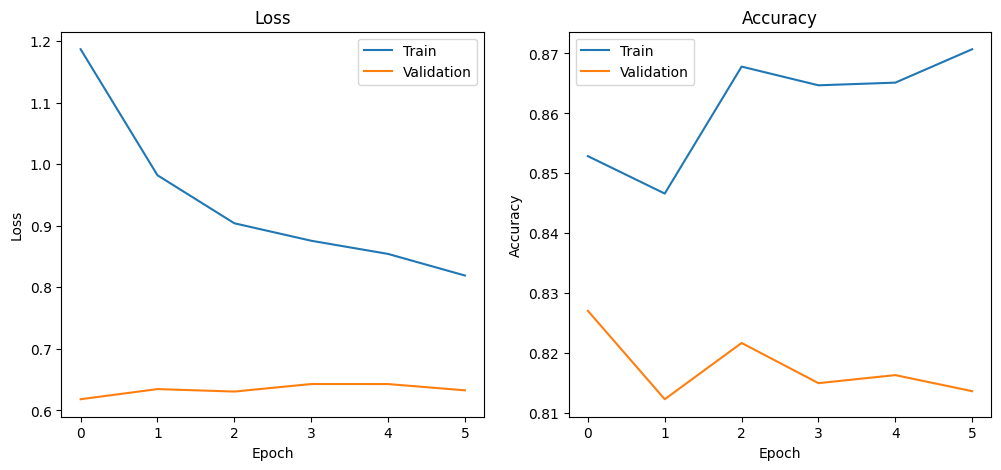


----- Final Evaluation After Distillation -----

Evaluating ResNet50 Student (After Distillation):


Evaluating ResNet50_Distilled: 100%|███████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.53it/s]


ResNet50_Distilled Accuracy: 83.38%

Classification Report for ResNet50_Distilled:
              precision    recall  f1-score   support

          25       0.93      0.98      0.96        56
          28       0.47      0.50      0.48        32
          29       0.83      0.80      0.81        71
          30       0.94      1.00      0.97        48
          31       0.65      0.54      0.59        24
          32       0.59      0.71      0.64        24
          33       0.84      0.72      0.78        29
          34       0.89      0.91      0.90        34
          35       0.64      0.54      0.58        13
          37       0.89      0.99      0.93        79
          38       0.96      0.87      0.91        85
          40       0.80      0.80      0.80        30
          41       0.92      0.89      0.91        27
          42       0.97      0.97      0.97        31
          43       0.87      0.68      0.76        19
          54       0.74      0.83      0.78        8

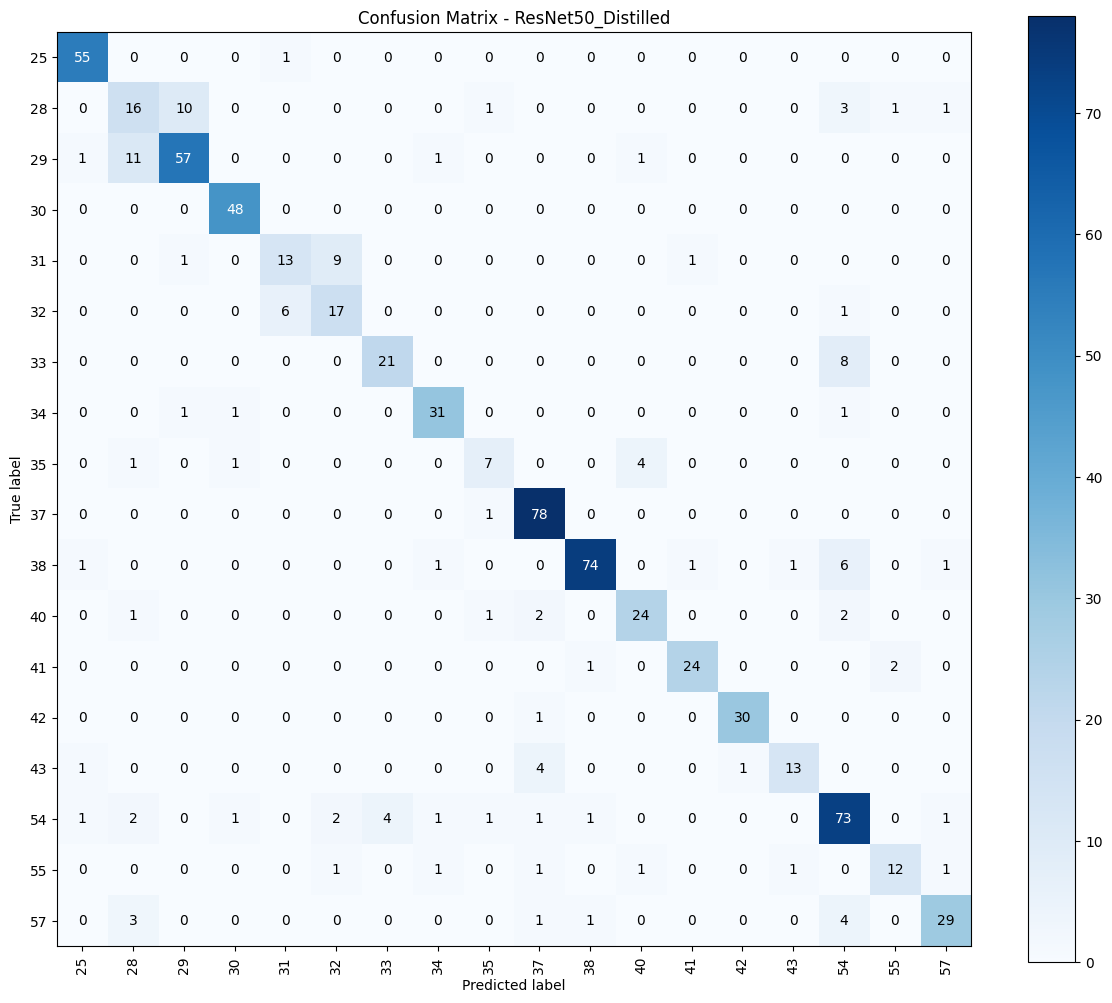


Evaluating EfficientNetB2 Student (After Distillation):


Evaluating EfficientNetB2_Distilled: 100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.13it/s]


EfficientNetB2_Distilled Accuracy: 82.71%

Classification Report for EfficientNetB2_Distilled:
              precision    recall  f1-score   support

          25       0.95      0.93      0.94        56
          28       0.51      0.56      0.54        32
          29       0.75      0.72      0.73        71
          30       0.94      0.96      0.95        48
          31       0.76      0.67      0.71        24
          32       0.69      0.75      0.72        24
          33       0.74      0.79      0.77        29
          34       0.86      0.88      0.87        34
          35       0.83      0.77      0.80        13
          37       0.90      0.97      0.93        79
          38       0.90      0.91      0.90        85
          40       0.78      0.70      0.74        30
          41       1.00      0.81      0.90        27
          42       0.94      1.00      0.97        31
          43       0.93      0.68      0.79        19
          54       0.72      0.84      0

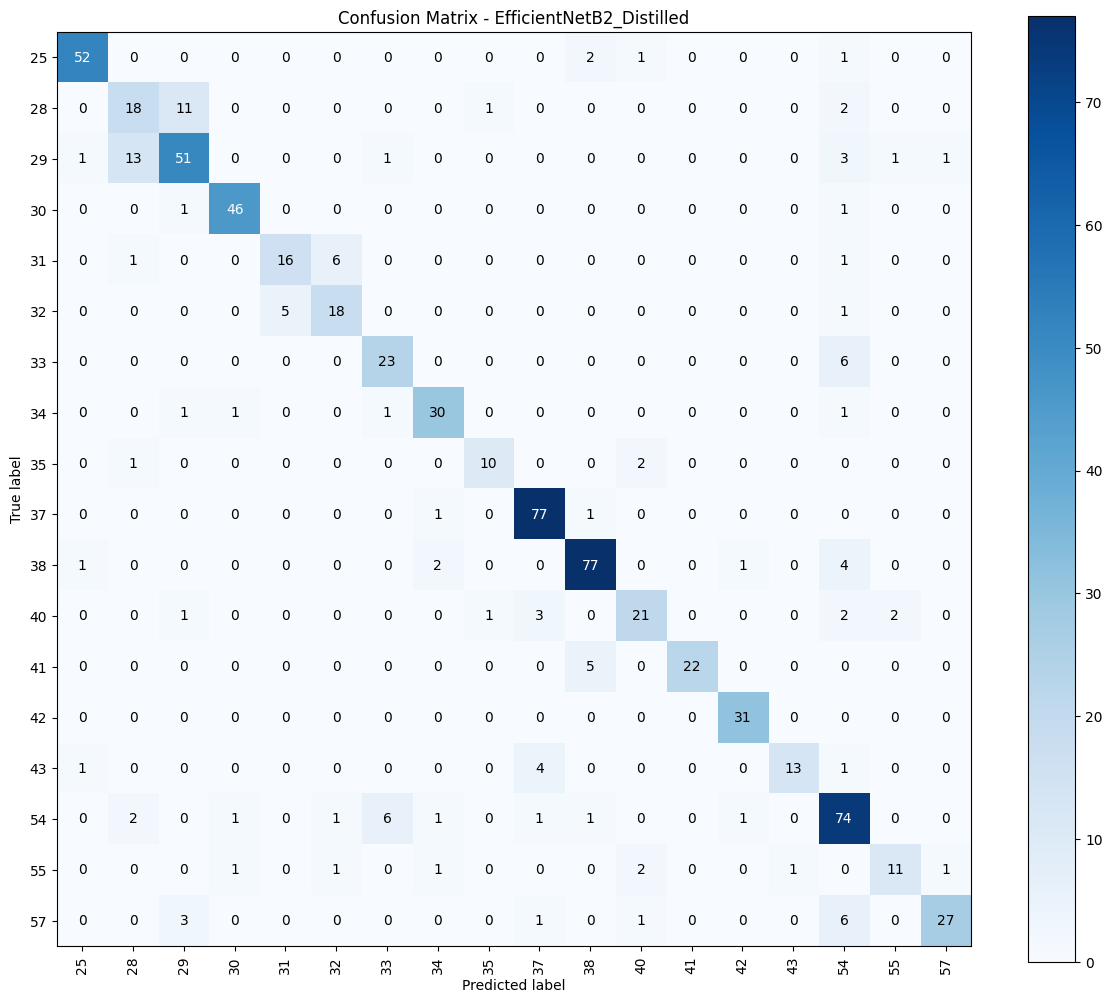


----- Ensemble Model Evaluation -----
Testing different ensemble weight schemes:

Weights: Teacher=0.6, ResNet=0.2, EfficientNet=0.2


Evaluating ensemble: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.83it/s]


Ensemble Accuracy: 83.38%

Weights: Teacher=0.4, ResNet=0.3, EfficientNet=0.3


Evaluating ensemble: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.80it/s]


Ensemble Accuracy: 84.32%

Weights: Teacher=0.33, ResNet=0.33, EfficientNet=0.34


Evaluating ensemble: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.79it/s]

Ensemble Accuracy: 83.78%

Best Ensemble Weights: Teacher=0.4, ResNet=0.3, EfficientNet=0.3
Best Ensemble Accuracy: 84.32%

----- Model Performance Comparison -----
Teacher (ViT): 82.04%
ResNet50 Initial: 82.04%
ResNet50 After Distillation: 83.38%
EfficientNetB2 Initial: 82.98%
EfficientNetB2 After Distillation: 82.71%
Best Ensemble: 84.32%

Ensemble configuration saved to ensemble_config.json


In [12]:
# Training function with knowledge distillation
def train_with_distillation(student_model, teacher_model, criterion, optimizer, scheduler=None, 
                           num_epochs=30, patience=5, alpha=0.5, temperature=2.0,
                           save_path=None, student_name="student"):
    """Train student model with knowledge distillation from teacher."""
    since = time.time()
    
    best_model_wts = copy.deepcopy(student_model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    # Create distillation loss
    distillation_criterion = DistillationLoss(alpha=alpha, temperature=temperature)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                student_model.train()  # Set model to training mode
            else:
                student_model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Get teacher predictions (no grad needed)
                    with torch.no_grad():
                        teacher_outputs = teacher_model(inputs)
                    
                    # Get student predictions
                    student_outputs = student_model(inputs)
                    _, preds = torch.max(student_outputs, 1)
                    
                    if phase == 'train':
                        # Use distillation loss in training
                        loss = distillation_criterion(student_outputs, teacher_outputs, labels)
                    else:
                        # Use regular CE loss for validation
                        loss = criterion(student_outputs, labels)
                    
                    # Backward pass + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if scheduler:
                    scheduler.step()
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model if it's the best
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(student_model.state_dict())
                    early_stop_counter = 0
                    
                    # Save current best model
                    if save_path:
                        torch.save({
                            'model_state_dict': student_model.state_dict(),
                            'class_names': class_names,
                            'epoch': epoch,
                            'accuracy': epoch_acc.item(),
                            'optimizer': optimizer.state_dict(),
                        }, save_path)
                        print(f"Saved improved model to {save_path}")
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print(f"Early stopping triggered after {epoch+1} epochs! Best model restored.")
                        student_model.load_state_dict(best_model_wts)
                        
                        # Plot training history before early stopping
                        plt.figure(figsize=(12, 5))
                        plt.subplot(1, 2, 1)
                        plt.plot(history['train_loss'], label='Train')
                        plt.plot(history['val_loss'], label='Validation')
                        plt.title('Loss')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.legend()
                        
                        plt.subplot(1, 2, 2)
                        plt.plot(history['train_acc'], label='Train')
                        plt.plot(history['val_acc'], label='Validation')
                        plt.title('Accuracy')
                        plt.xlabel('Epoch')
                        plt.ylabel('Accuracy')
                        plt.legend()
                        plt.savefig(f"{student_name}_training_history.png")
                        plt.show()
                        
                        return student_model, history
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"{student_name}_training_history.png")
    plt.show()
    
    # Load best model weights
    student_model.load_state_dict(best_model_wts)
    return student_model, history

# Evaluate model
def evaluate_model(model, dataloader, model_name="Model"):
    """Evaluate model performance on provided dataloader."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'{model_name} Accuracy: {accuracy*100:.2f}%')
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    
    # Label the confusion matrix
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()
    
    return accuracy

# Ensemble prediction function
def ensemble_predict(teacher_model, resnet_student, efficientnet_student, image_path, weights=[0.6, 0.2, 0.2]):
    """Make an ensemble prediction using weighted voting from all three models."""
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Load and transform image
    img = Image.open(image_path)
    img_transform = data_transforms['val']
    img_tensor = img_transform(img).unsqueeze(0).to(device)
    
    # Set all models to eval mode
    teacher_model.eval()
    resnet_student.eval()
    efficientnet_student.eval()
    
    with torch.no_grad():
        # Get predictions from all models
        teacher_output = teacher_model(img_tensor)
        resnet_output = resnet_student(img_tensor)
        efficientnet_output = efficientnet_student(img_tensor)
        
        # Convert to probabilities
        teacher_probs = F.softmax(teacher_output, dim=1)
        resnet_probs = F.softmax(resnet_output, dim=1)
        efficientnet_probs = F.softmax(efficientnet_output, dim=1)
        
        # Weighted ensemble
        ensemble_probs = (weights[0] * teacher_probs + 
                          weights[1] * resnet_probs + 
                          weights[2] * efficientnet_probs)
        
        # Get prediction
        _, ensemble_pred = torch.max(ensemble_probs, 1)
        confidence = ensemble_probs[0][ensemble_pred].item() * 100
        predicted_class = class_names[ensemble_pred.item()]
        
        # Get top 3 predictions
        top3_prob, top3_idx = torch.topk(ensemble_probs[0], 3)
        top3_classes = [class_names[idx.item()] for idx in top3_idx]
        top3_probs = [prob.item() * 100 for prob in top3_prob]
    
    # Display image with predictions
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    img_display = transforms.Resize((224, 224))(img)
    plt.imshow(np.array(img_display))
    plt.title(f"Ensemble Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    
    # Display top 3 predictions as bar chart
    plt.subplot(2, 1, 2)
    plt.barh(top3_classes, top3_probs, color='skyblue')
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions (Ensemble)')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.savefig("ensemble_prediction.png")
    plt.show()
    
    # Also display individual model predictions
    individual_preds = [
        (class_names[torch.max(teacher_probs, 1)[1].item()], 
         teacher_probs[0][torch.max(teacher_probs, 1)[1]].item() * 100),
        (class_names[torch.max(resnet_probs, 1)[1].item()], 
         resnet_probs[0][torch.max(resnet_probs, 1)[1]].item() * 100),
        (class_names[torch.max(efficientnet_probs, 1)[1].item()], 
         efficientnet_probs[0][torch.max(efficientnet_probs, 1)[1]].item() * 100)
    ]
    
    print("Individual model predictions:")
    print(f"Teacher (ViT): {individual_preds[0][0]} ({individual_preds[0][1]:.2f}%)")
    print(f"ResNet50: {individual_preds[1][0]} ({individual_preds[1][1]:.2f}%)")
    print(f"EfficientNetB2: {individual_preds[2][0]} ({individual_preds[2][1]:.2f}%)")
    print(f"Ensemble: {predicted_class} ({confidence:.2f}%)")
    
    return predicted_class, confidence, individual_preds

# MAIN SECTION - THIS RUNS WHEN YOU EXECUTE THE NOTEBOOK

# Load paths - Replace these with your actual paths
TEACHER_PATH = 'vit_insect_classifier.pth'
RESNET_PATH = 'resnet50_finetuned.pth'  # Path to your pretrained ResNet50 model
EFFICIENTNET_PATH = 'efficientnet_b2_finetuned.pth'  # Path to your pretrained EfficientNetB2 model

# 1. Load all models
print("Loading models...")
teacher_model = load_model(create_teacher_model, TEACHER_PATH, "Teacher (ViT)")
resnet_student = load_model(create_resnet_student, RESNET_PATH, "ResNet50")
efficientnet_student = load_model(create_efficientnet_student, EFFICIENTNET_PATH, "EfficientNetB2")

# Check if all models loaded successfully
if None in [teacher_model, resnet_student, efficientnet_student]:
    print("Error: One or more models failed to load. Please check the paths and model formats.")
else:
    # 2. Set all models to evaluation mode for initial evaluation
    teacher_model.eval()
    resnet_student.eval()
    efficientnet_student.eval()
    
    # 3. [OPTIONAL] Initial evaluation of models before distillation
    print("\n----- Initial Model Evaluation -----")
    print("Evaluating Teacher (ViT):")
    teacher_acc = evaluate_model(teacher_model, dataloaders['val'], "Teacher_ViT_Initial")
    
    print("\nEvaluating ResNet50 Student (Before Distillation):")
    resnet_acc_init = evaluate_model(resnet_student, dataloaders['val'], "ResNet50_Initial")
    
    print("\nEvaluating EfficientNetB2 Student (Before Distillation):")
    efficientnet_acc_init = evaluate_model(efficientnet_student, dataloaders['val'], "EfficientNetB2_Initial")
    
    # 4. Knowledge Distillation Phase
    print("\n----- Starting Knowledge Distillation -----")

    # 4.1. Distill to ResNet50
    print("\n----- Distilling to ResNet50 -----")
    # Set distillation parameters
    alpha_resnet = 0.5  # Balance between soft and hard loss (higher = more distillation)
    temperature_resnet = 3.0  # Controls softness of probability distribution
    
    criterion = nn.CrossEntropyLoss()
    optimizer_resnet = optim.AdamW(resnet_student.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler_resnet = optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=10, eta_min=1e-6)
    
    resnet_student, resnet_history = train_with_distillation(
        resnet_student, teacher_model, criterion, optimizer_resnet, scheduler_resnet,
        num_epochs=30, patience=5, alpha=alpha_resnet, temperature=temperature_resnet,
        save_path='resnet50_distilled.pth', student_name="ResNet50"
    )
    
    # 4.2. Distill to EfficientNetB2
    print("\n----- Distilling to EfficientNetB2 -----")
    # Set distillation parameters
    alpha_efficientnet = 0.5
    temperature_efficientnet = 3.0
    
    optimizer_efficientnet = optim.AdamW(efficientnet_student.parameters(), lr=1e-4, weight_decay=5e-5)
    scheduler_efficientnet = optim.lr_scheduler.CosineAnnealingLR(optimizer_efficientnet, T_max=30, eta_min=1e-6)
    
    efficientnet_student, efficientnet_history = train_with_distillation(
        efficientnet_student, teacher_model, criterion, optimizer_efficientnet, scheduler_efficientnet,
        num_epochs=30, patience=5, alpha=alpha_efficientnet, temperature=temperature_efficientnet,
        save_path='efficientnet_b2_distilled.pth', student_name="EfficientNetB2"
    )
    
    # 5. Final Evaluation After Distillation
    print("\n----- Final Evaluation After Distillation -----")
    
    print("\nEvaluating ResNet50 Student (After Distillation):")
    resnet_acc_final = evaluate_model(resnet_student, dataloaders['val'], "ResNet50_Distilled")
    
    print("\nEvaluating EfficientNetB2 Student (After Distillation):")
    efficientnet_acc_final = evaluate_model(efficientnet_student, dataloaders['val'], "EfficientNetB2_Distilled")
    
    # 6. Ensemble Performance
    print("\n----- Ensemble Model Evaluation -----")
    # Try different weighting schemes
    weight_schemes = [
        [0.6, 0.2, 0.2],  # Teacher-dominated
        [0.4, 0.3, 0.3],  # More balanced
        [0.33, 0.33, 0.34]  # Equal weighting
    ]
    
    # Evaluate ensemble on validation set
    correct = 0
    total = 0
    best_weights = None
    best_acc = 0
    
    print("Testing different ensemble weight schemes:")
    for weights in weight_schemes:
        print(f"\nWeights: Teacher={weights[0]}, ResNet={weights[1]}, EfficientNet={weights[2]}")
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['val'], desc="Evaluating ensemble"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Get predictions from all models
                teacher_output = teacher_model(inputs)
                resnet_output = resnet_student(inputs)
                efficientnet_output = efficientnet_student(inputs)
                
                # Convert to probabilities
                teacher_probs = F.softmax(teacher_output, dim=1)
                resnet_probs = F.softmax(resnet_output, dim=1)
                efficientnet_probs = F.softmax(efficientnet_output, dim=1)
                
                # Weighted ensemble
                ensemble_probs = (weights[0] * teacher_probs + 
                                weights[1] * resnet_probs + 
                                weights[2] * efficientnet_probs)
                
                # Get predictions
                _, preds = torch.max(ensemble_probs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        ensemble_acc = correct / total
        print(f"Ensemble Accuracy: {ensemble_acc*100:.2f}%")
        
        if ensemble_acc > best_acc:
            best_acc = ensemble_acc
            best_weights = weights
    
    print(f"\nBest Ensemble Weights: Teacher={best_weights[0]}, ResNet={best_weights[1]}, EfficientNet={best_weights[2]}")
    print(f"Best Ensemble Accuracy: {best_acc*100:.2f}%")
    
    # 7. Compare model performances
    print("\n----- Model Performance Comparison -----")
    print(f"Teacher (ViT): {teacher_acc*100:.2f}%")
    print(f"ResNet50 Initial: {resnet_acc_init*100:.2f}%")
    print(f"ResNet50 After Distillation: {resnet_acc_final*100:.2f}%")
    print(f"EfficientNetB2 Initial: {efficientnet_acc_init*100:.2f}%")
    print(f"EfficientNetB2 After Distillation: {efficientnet_acc_final*100:.2f}%")
    print(f"Best Ensemble: {best_acc*100:.2f}%")
    
    # 8. Save the ensemble configuration
    ensemble_config = {
        'weights': best_weights,
        'accuracy': best_acc,
        'teacher_model': TEACHER_PATH,
        'resnet_model': 'resnet50_distilled.pth',
        'efficientnet_model': 'efficientnet_b2_distilled.pth'
    }
    
    import json
    with open('ensemble_config.json', 'w') as f:
        json.dump(ensemble_config, f)
    
    print("\nEnsemble configuration saved to ensemble_config.json")


----- Visualizing Ensemble Predictions -----


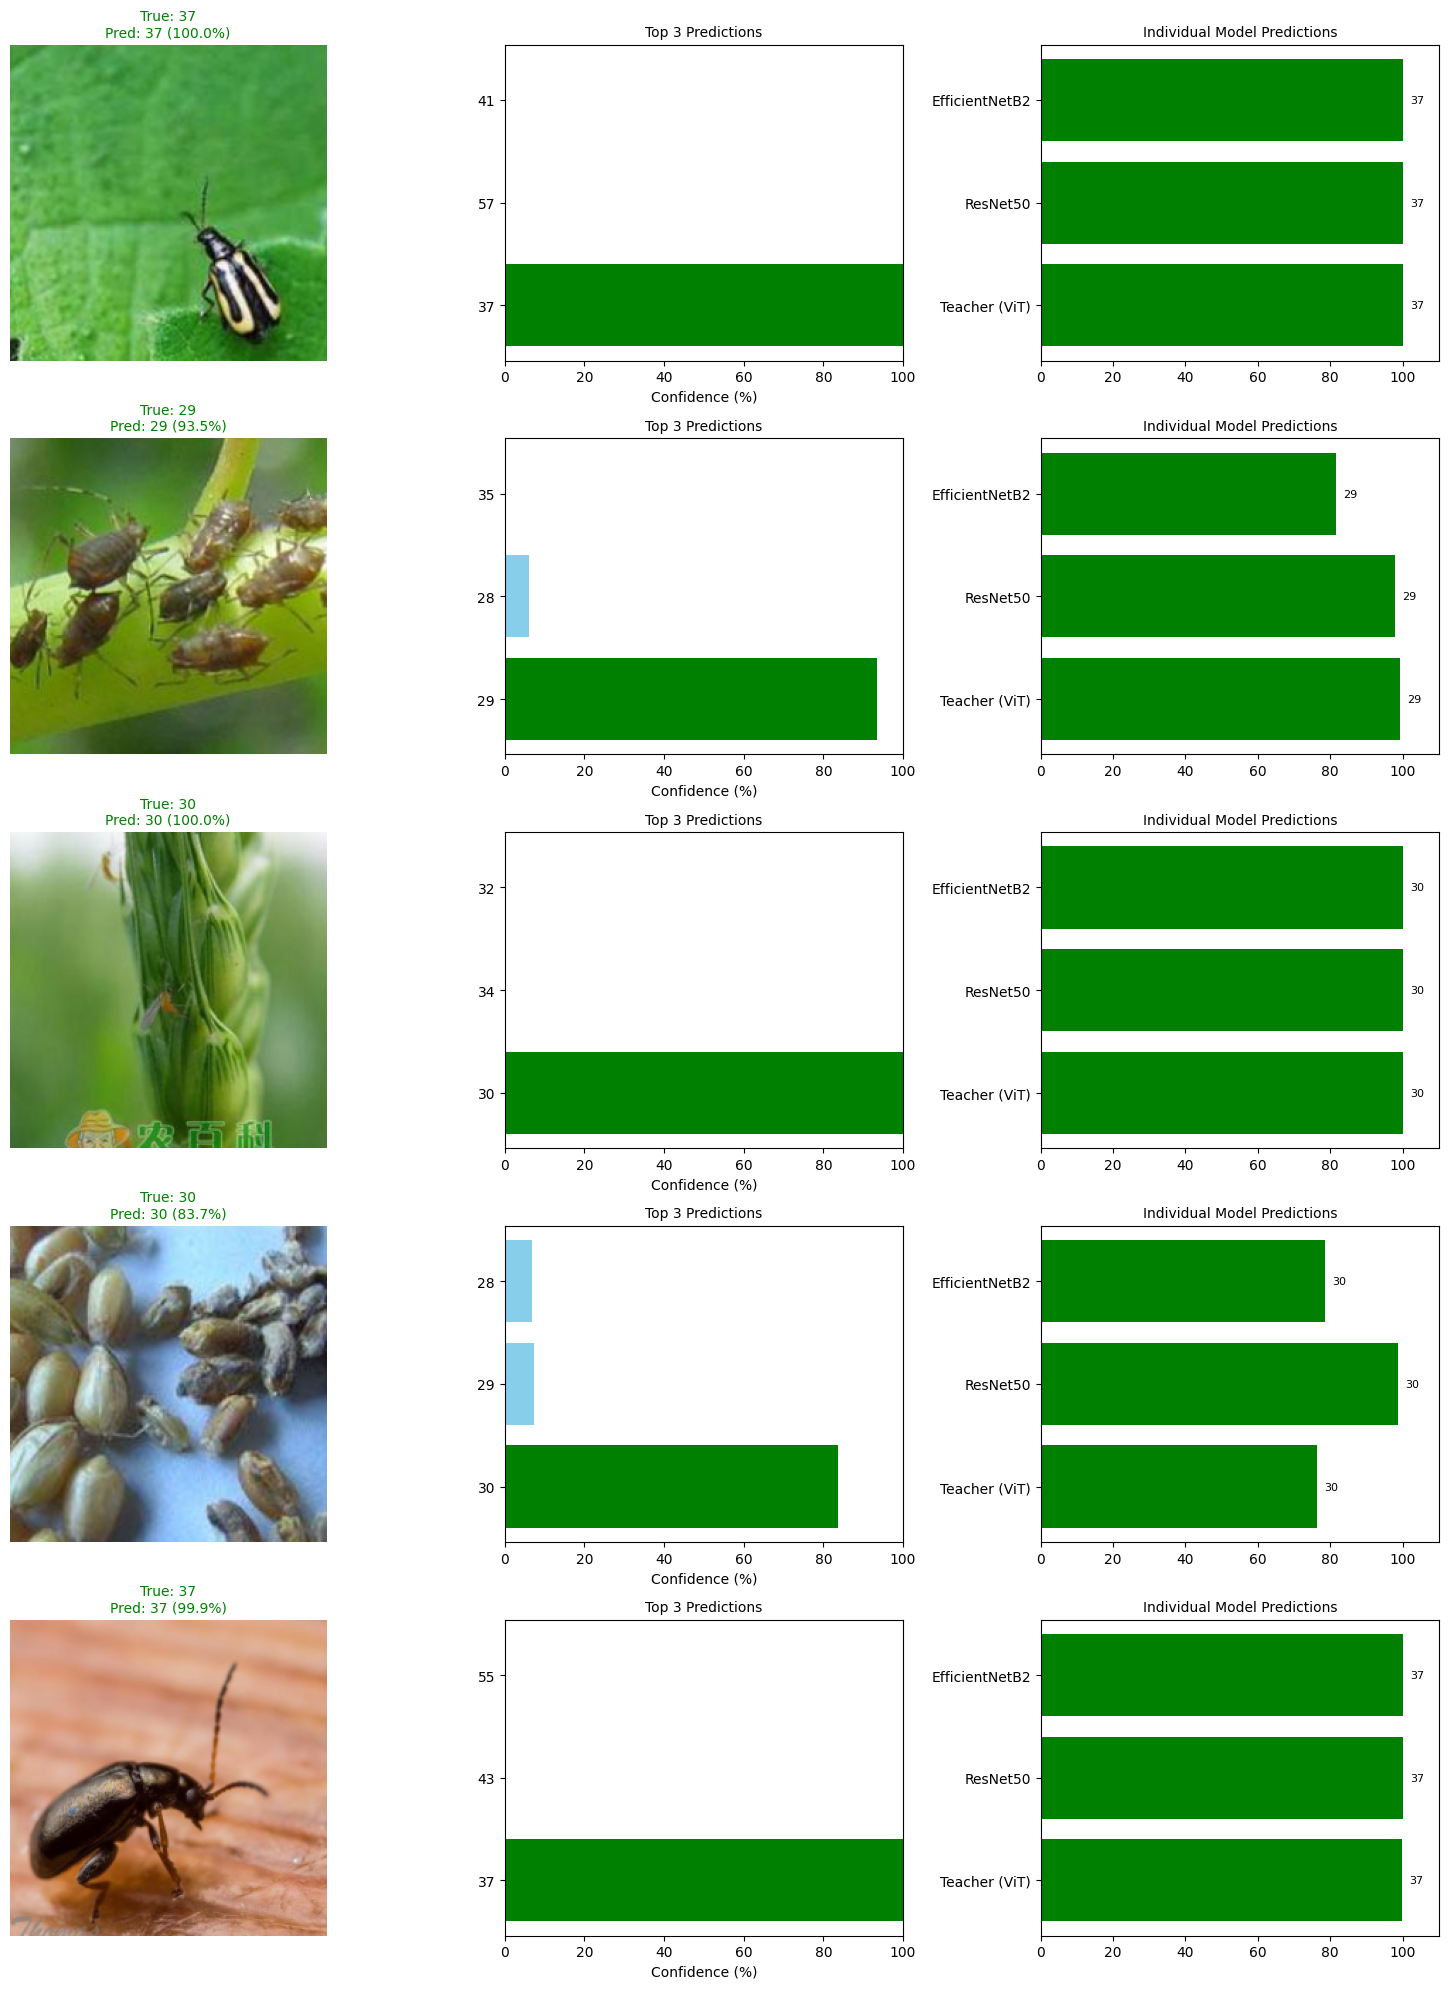

Predictions visualized and saved to 'ensemble_predictions_results.png'


In [13]:
def predict_and_visualize_samples(teacher_model, resnet_student, efficientnet_student, num_samples=5, weights=[0.6, 0.2, 0.2]):
    # Set all models to eval mode
    teacher_model.eval()
    resnet_student.eval()
    efficientnet_student.eval()
    
    # Get a dataloader that doesn't shuffle so we can get the same images each time
    test_loader = DataLoader(image_datasets['val'], batch_size=1, shuffle=True, num_workers=4)
    
    # Get some random samples
    samples = []
    labels = []
    count = 0
    for inputs, targets in test_loader:
        if count >= num_samples:
            break
        samples.append(inputs)
        labels.append(targets)
        count += 1
    
    # Create a figure to show the predictions
    fig = plt.figure(figsize=(15, 4 * num_samples))
    
    # Loop through each sample
    for i, (img_tensor, label) in enumerate(zip(samples, labels)):
        img_tensor = img_tensor.to(device)
        true_class = class_names[label.item()]
        
        with torch.no_grad():
            # Get predictions from all models
            teacher_output = teacher_model(img_tensor)
            resnet_output = resnet_student(img_tensor)
            efficientnet_output = efficientnet_student(img_tensor)
            
            # Convert to probabilities
            teacher_probs = F.softmax(teacher_output, dim=1)
            resnet_probs = F.softmax(resnet_output, dim=1)
            efficientnet_probs = F.softmax(efficientnet_output, dim=1)
            
            # Weighted ensemble
            ensemble_probs = (weights[0] * teacher_probs + 
                             weights[1] * resnet_probs + 
                             weights[2] * efficientnet_probs)
            
            # Get ensemble prediction
            _, ensemble_pred = torch.max(ensemble_probs, 1)
            predicted_class = class_names[ensemble_pred.item()]
            confidence = ensemble_probs[0][ensemble_pred].item() * 100
            
            # Get individual model predictions
            _, teacher_pred = torch.max(teacher_probs, 1)
            _, resnet_pred = torch.max(resnet_probs, 1)
            _, efficientnet_pred = torch.max(efficientnet_probs, 1)
            
            teacher_class = class_names[teacher_pred.item()]
            resnet_class = class_names[resnet_pred.item()]
            efficientnet_class = class_names[efficientnet_pred.item()]
            
            # Get top 3 predictions
            top3_prob, top3_idx = torch.topk(ensemble_probs[0], 3)
            top3_classes = [class_names[idx.item()] for idx in top3_idx]
            top3_probs = [prob.item() * 100 for prob in top3_prob]
        
        # Display image with predictions
        # First subplot: Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        img = img_tensor.cpu().squeeze().permute(1, 2, 0)
        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        plt.imshow(img)
        # Set title color based on prediction correctness
        title_color = 'green' if predicted_class == true_class else 'red'
        plt.title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.1f}%)", 
                 color=title_color, fontsize=10)
        plt.axis('off')
        
        # Second subplot: Top 3 predictions
        plt.subplot(num_samples, 3, i*3 + 2)
        colors = ['green' if cls == true_class else 'skyblue' for cls in top3_classes]
        plt.barh(top3_classes, top3_probs, color=colors)
        plt.xlabel('Confidence (%)')
        plt.title('Top 3 Predictions', fontsize=10)
        plt.xlim(0, 100)
        
        # Third subplot: Individual model predictions
        plt.subplot(num_samples, 3, i*3 + 3)
        models = ['Teacher (ViT)', 'ResNet50', 'EfficientNetB2']
        predictions = [teacher_class, resnet_class, efficientnet_class]
        accuracies = [
            teacher_probs[0][teacher_pred].item() * 100,
            resnet_probs[0][resnet_pred].item() * 100,
            efficientnet_probs[0][efficientnet_pred].item() * 100
        ]
        
        # Color bars based on prediction correctness
        colors = ['green' if pred == true_class else 'salmon' for pred in predictions]
        
        # Create the bar plot
        bars = plt.barh(models, accuracies, color=colors)
        
        # Add prediction labels
        for j, (bar, pred) in enumerate(zip(bars, predictions)):
            plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
                    pred, va='center', fontsize=8)
        
        plt.xlim(0, 110)  # Make room for labels
        plt.title('Individual Model Predictions', fontsize=10)
        
    plt.tight_layout()
    plt.savefig("ensemble_predictions_results.png")
    plt.show()
    
    print(f"Predictions visualized and saved to 'ensemble_predictions_results.png'")
    return

# Run the prediction visualization on 5 random validation images
print("\n----- Visualizing Ensemble Predictions -----")
predict_and_visualize_samples(
    teacher_model, 
    resnet_student, 
    efficientnet_student,
    num_samples=5,  # You can change this number to visualize more or fewer samples
    weights=best_weights  # Using the best weights from our earlier evaluation
)